# Reddit Comment Trends & EDA

### Imports & Loading

In [85]:
import time
import praw
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

### WebScraping

In [73]:
with open('keys.json') as f:
    key = json.loads(f.read())

In [74]:
reddit = praw.Reddit(client_id=key['client_id'],
                     client_secret=key['client_secret'],
                     password=key['password'],
                     user_agent=key['user_agent'],
                     username=key['username'])

Version 5.3.0 of praw is outdated. Version 5.4.0 was released 1 day ago.


In [86]:
def scrap_time(sub,start=1514764800,end=round(time.time())):
    """
    pulls all subreddit threads from January 1st 2018 till now, unless specified
    collects post:
    Title, Score, # of Comments, Post Date, Is_video(boolean)
    """
    funny = reddit.subreddit(sub)
    hot_funny = funny.submissions(start,end)

    funny_list = []
    for submit in tqdm(hot_funny):
        if not submit.stickied:
            fun = {}
            fun['title'] = submit.title
            fun['score'] = submit.ups
            fun['comments'] = submit.num_comments
            fun['date'] = datetime.datetime.fromtimestamp(submit.created)
            fun['is_video'] = submit.is_video
            funny_list.append(fun)
    df = pd.DataFrame(funny_list)
    return(df)

In [ ]:
#cry = scrap_time('CryptoCurrency',1508889600,1522090807)

In [ ]:
#cry.to_csv('./Reddit_Crypto.csv')

### Cleaning

In [13]:
Crypto_2018 = pd.read_csv('./Cryto_2018.csv')

In [14]:
Crypto_2018.title = Crypto_2018.title.str.lower()
Crypto_2018 = Crypto_2018.drop('Unnamed: 0',axis=1)
Crypto_2018.date = pd.to_datetime(Crypto_2018['date'])
Crypto_2018['hour'] = Crypto_2018.date.dt.hour

#k is just a generic counter
Crypto_2018['k'] = 1

In [33]:
print("Number of duplicated posts, based on title: "+str(Crypto_2018.title.duplicated().sum()))

Number of duplicated posts, based on title: 357


In [34]:
#keeping only the last
Crypto_2018 = Crypto_2018.drop_duplicates('title',keep='last')

In [36]:
#because of skew, adding log values
Crypto_2018['log_score'] = np.log2(Crypto_2018[Crypto_2018['score']>0]['score'])
Crypto_2018['log_comments'] = np.log2(Crypto_2018[Crypto_2018['comments']>0]['comments'])
Crypto_2018 = Crypto_2018.fillna(0)

In [35]:
Crypto_2018.describe()

,comments,score,hour,k,log_score,log_comments
count,35599.000000,35599.000000,35599.000000,35599.0,35599.000000,35599.000000
mean,25.776539,57.062867,12.253631,1.0,2.367966,2.402838
std,253.884811,555.686870,7.527575,0.0,2.450925,2.000207
min,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,2.000000,1.000000,5.000000,1.0,0.000000,1.000000
50%,5.000000,4.000000,13.000000,1.0,2.000000,2.321928
75%,13.000000,12.000000,19.000000,1.0,3.584963,3.700440
max,14807.000000,53704.000000,23.000000,1.0,15.712742,13.853992


### EDA

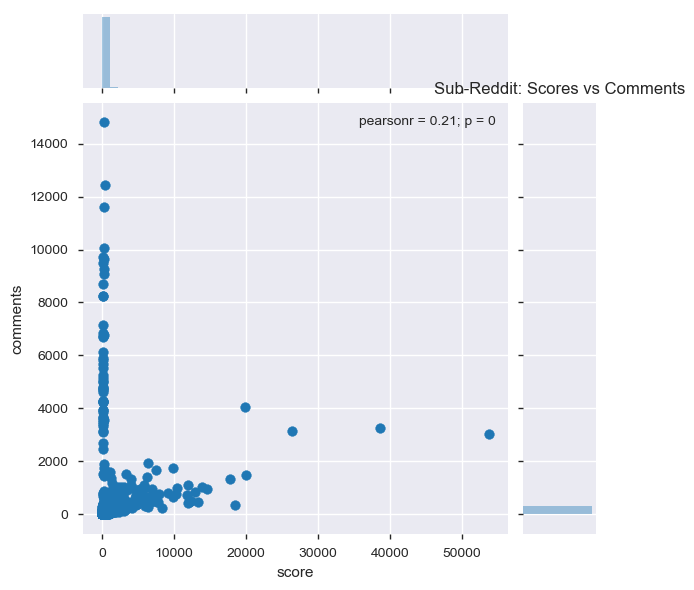

In [28]:
sns.jointplot(x='score',y='comments',data=Crypto_2018)
plt.title('Sub-Reddit: Scores vs Comments');

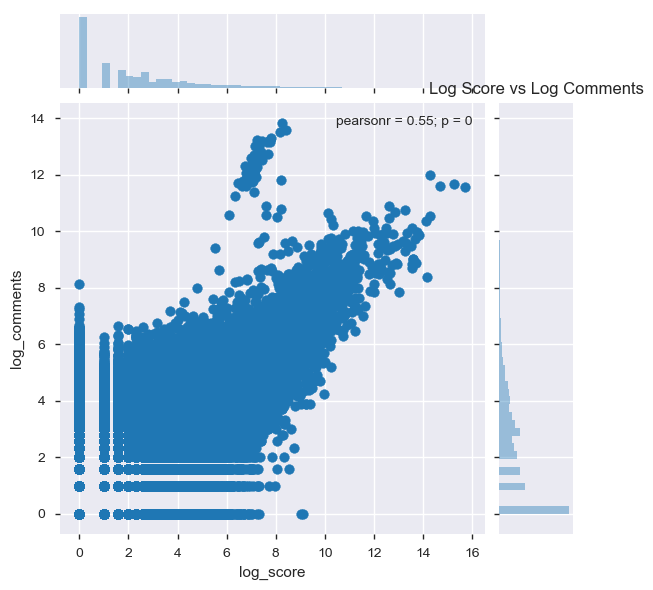

In [30]:
sns.jointplot(x='log_score',y='log_comments',data=Crypto_2018)
plt.title('Log Score vs Log Comments');

In [9]:
#huh whats that weird cluster?
Crypto_2018['odd_cluster'] = (Crypto_2018['log_comments']>7) & (Crypto_2018['log_score']<7)

Basic Model : How does a comments does a post need inorder to do better than the median of posts

In [11]:
np.median(Crypto_2018.comments)

5.0

In [12]:
#A median of 5?!?! thats nuts

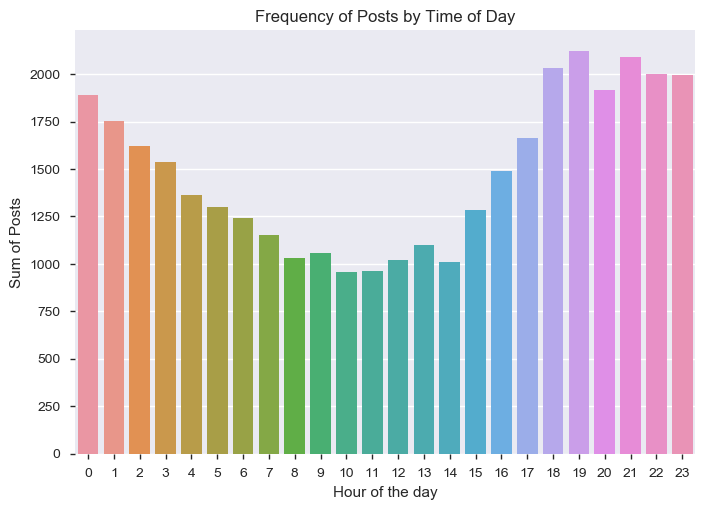

In [37]:
#frequency of posts over time of day
ax = sns.barplot(x=Crypto_2018.groupby('hour')['k'].sum().index, 
            y=Crypto_2018.groupby('hour')['k'].sum().values)
ax.set_title('Frequency of Posts by Time of Day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sum of Posts');

- This seems reasonable: to have more activity during the evening and less during the day

In [38]:
#lets find the average frequency of posts by hour
Crypto_2018.groupby('hour')['k'].sum().mean()

1483.2916666666667

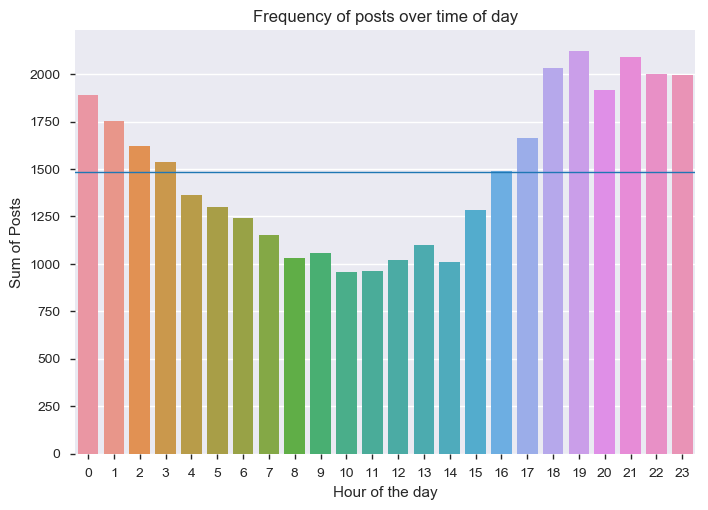

In [39]:
ax = sns.barplot(x=Crypto_2018.groupby('hour')['k'].sum().index, 
            y=Crypto_2018.groupby('hour')['k'].sum().values)
plt.plot([-1, 24 ], [Crypto_2018.groupby('hour')['k'].sum().mean(), 
                     Crypto_2018.groupby('hour')['k'].sum().mean()], 
         linewidth=1);
#frequency of posts over time of day
#line delineates above average post/time of day
ax.set_title('Frequency of posts over time of day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sum of Posts');

### Hourly Analysis

In [52]:
#making a new boolean column 'posting hours' and applying it to the main DF
ls=Crypto_2018.groupby('hour')['k'].sum()<Crypto_2018.groupby('hour')['k'].sum().mean()
dead_times_ls = [k for k in ls.values*[i for i in range(24)] if k>0]
Crypto_2018['peak_hours'] = False
Crypto_2018['peak_hours'] = ~Crypto_2018['hour'].isin(dead_times_ls)

In [53]:
#making a HOURLY_POSTS DF
hourly_posts = pd.DataFrame(Crypto_2018.groupby('hour')['k'].sum())
hourly_posts['peak_hours'] = ~hourly_posts.index.isin(dead_times_ls)

In [54]:
#making a prettier discrimator between peak hours and not
pretty_ls = Crypto_2018.groupby('hour')['k'].sum()-Crypto_2018.groupby('hour')['k'].sum().mean()
pretty_dead_times_ls = [k for k in pretty_ls.values*[i for i in range(24)] if k>0]

hourly_posts['pretty_dead']=pretty_ls

In [55]:
hourly_posts = hourly_posts.rename(columns={
    'Sum of Posts':'','k':'Sum of Posts',
    'peak_hours':'During Peak Hours'})

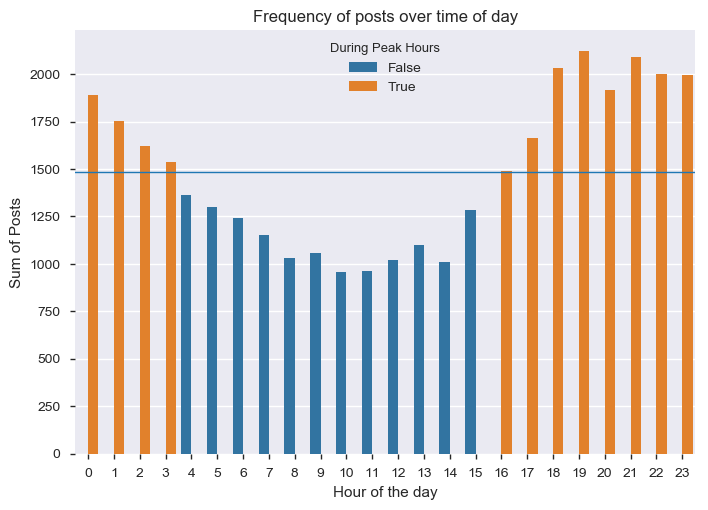

In [56]:
ax = sns.barplot(x=hourly_posts.index, 
            y='Sum of Posts',
            data = hourly_posts,
            hue='During Peak Hours')

plt.plot([-1, 24 ], [Crypto_2018.groupby('hour')['k'].sum().mean(), 
                     Crypto_2018.groupby('hour')['k'].sum().mean()], 
         linewidth=1);
#frequency of posts over time of day
ax.set_title('Frequency of posts over time of day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sum of Posts');

In [57]:
hourly_posts['Mean of Scores'] = Crypto_2018.groupby('hour')['score'].mean()
hourly_posts['Sum of Scores'] = Crypto_2018.groupby('hour')['score'].sum()
hourly_posts['Mean of Comments'] = Crypto_2018.groupby('hour')['score'].mean()
hourly_posts['Sum of Comments'] = Crypto_2018.groupby('hour')['score'].sum()

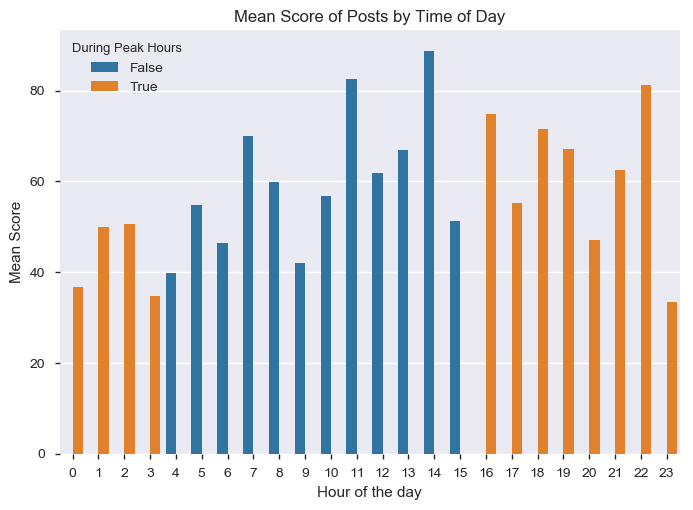

In [58]:
ax = sns.barplot(x=hourly_posts.index, 
            y='Mean of Scores',
            data=hourly_posts,
            hue='During Peak Hours')

ax.set_title('Mean Score of Posts by Time of Day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Mean Score');
#mean score of posts over time of day

- So that despite the low # of posts during the end of the 'not peak hours' there is enough activity, that when scaled by post volume we had a slightly different trend
- This suggests two things:
    - While there is a trend for activity 'high'(16:00->3:00) & 'low'(4:00->15:00)
    - There is a secondary trend for likiness of scoring 'high'(10:00->19:00) & 'low'(20:00->9:00)
    - This makes sense as there may be trends were viewers 'comment & post' vs 'skim & score/like'

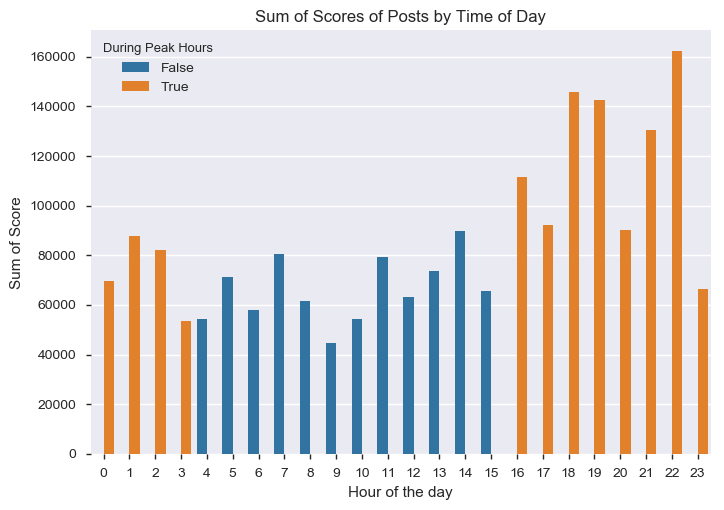

In [59]:
ax = sns.barplot(x=hourly_posts.index, 
            y='Sum of Scores',
            data=hourly_posts,
            hue='During Peak Hours')

ax.set_title('Sum of Scores of Posts by Time of Day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sum of Score');
#mean score of posts over time of day

- This surprises nobody as if people are more likely to score & post during the overlap of the two trends, you have this level of volitlity

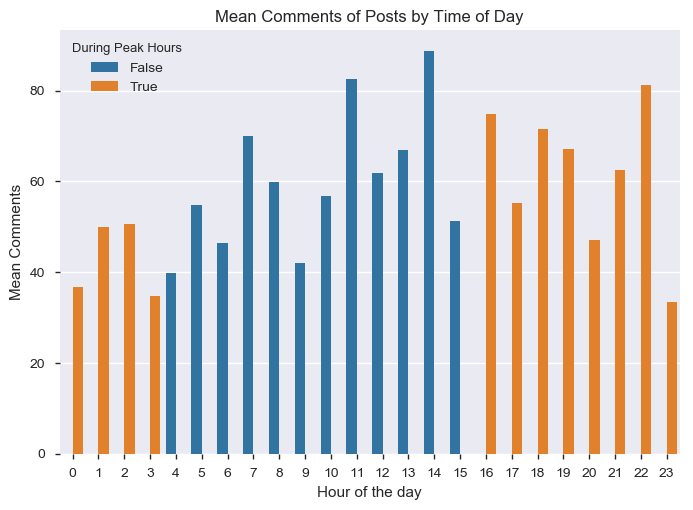

In [61]:
ax = sns.barplot(x=hourly_posts.index, 
            y='Mean of Comments',
            data=hourly_posts,
            hue='During Peak Hours')


ax.set_title('Mean Comments of Posts by Time of Day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Mean Comments');
#mean score of posts over time of day

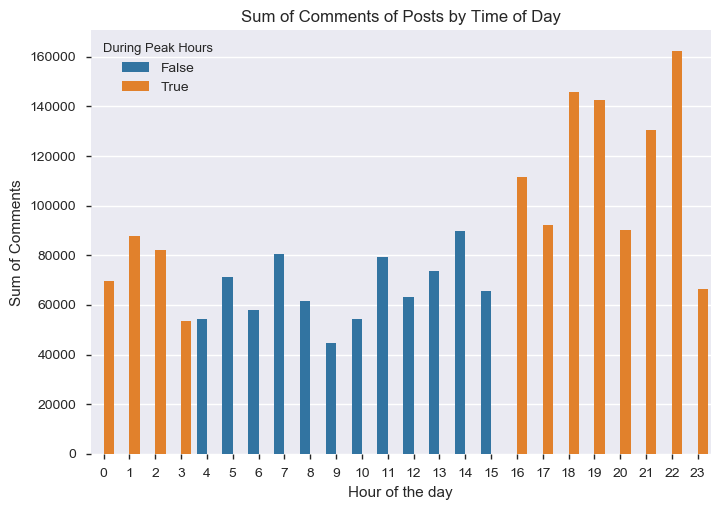

In [62]:
ax = sns.barplot(x=hourly_posts.index, 
            y='Sum of Comments',
            data=hourly_posts,
            hue='During Peak Hours')

ax.set_title('Sum of Comments of Posts by Time of Day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sum of Comments');
#ax.set_xlim(left=0,right=24)
#mean score of posts over time of day

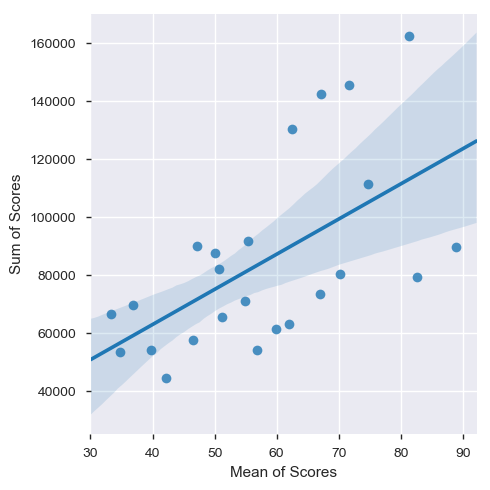

In [63]:
sns.lmplot(x='Mean of Scores',y='Sum of Scores',data=hourly_posts)

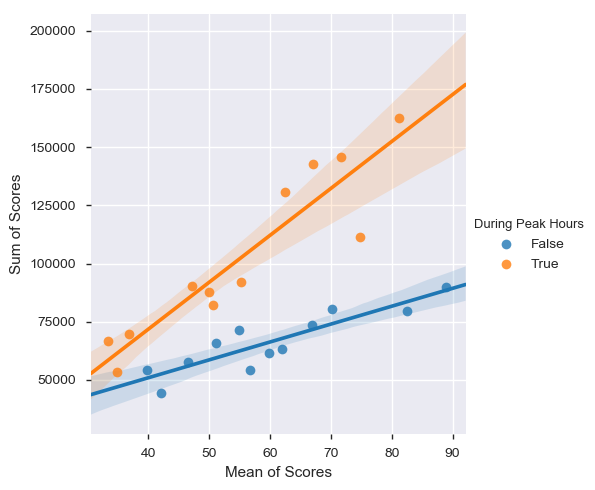

In [64]:
sns.lmplot(x='Mean of Scores',y='Sum of Scores',data=hourly_posts, hue='During Peak Hours')

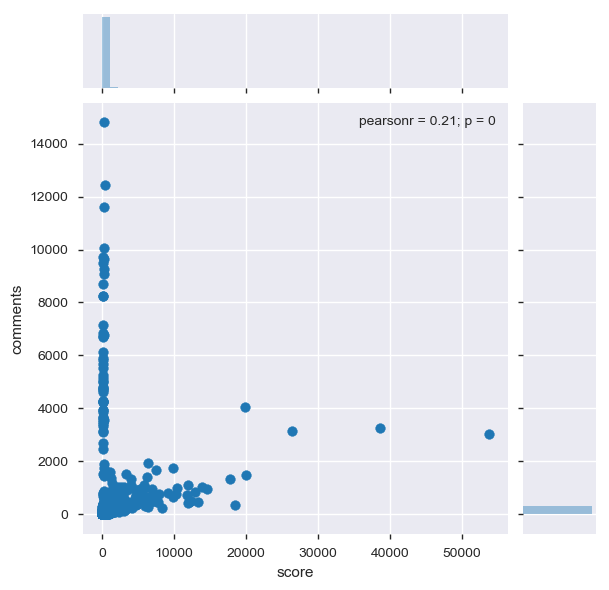

In [65]:
#inital scatter plot of scores and comments

ax = sns.jointplot(x='score',y='comments',data=Crypto_2018,);
#ax.set_title('Scatterplot of comments & scores');

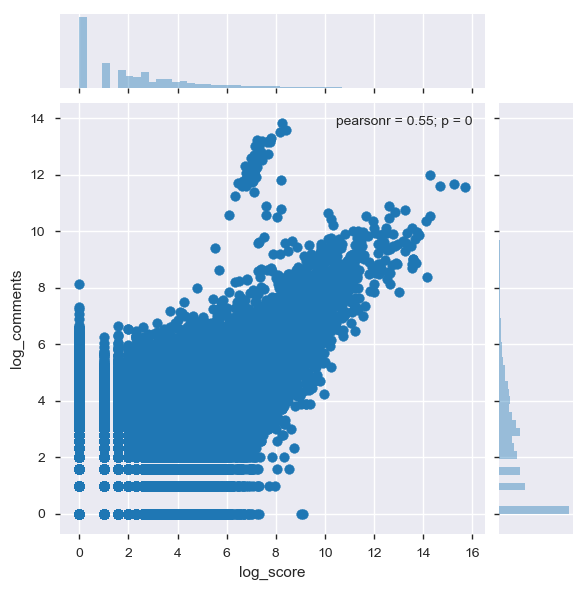

In [66]:
#inital log scores and log comments of overall data

sns.jointplot(x='log_score',y='log_comments',data=Crypto_2018,);

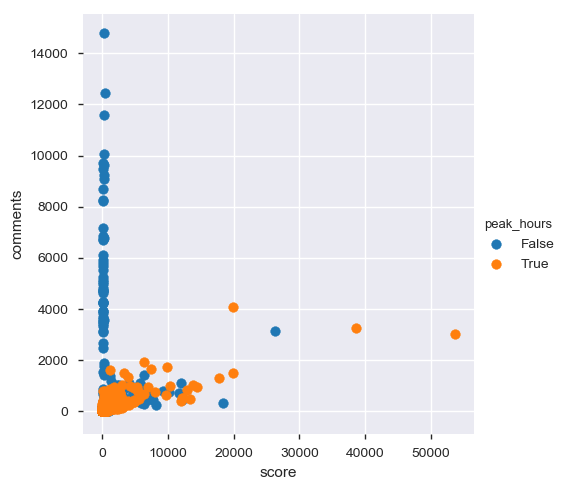

In [67]:
#scatter plot of scores and comments, organized by peak hours
#notice the heavily commented & unscored posts were during non-peak hours

ax = sns.FacetGrid(Crypto_2018,hue='peak_hours',size=5) \
    .map(plt.scatter,'score','comments')\
    .add_legend()

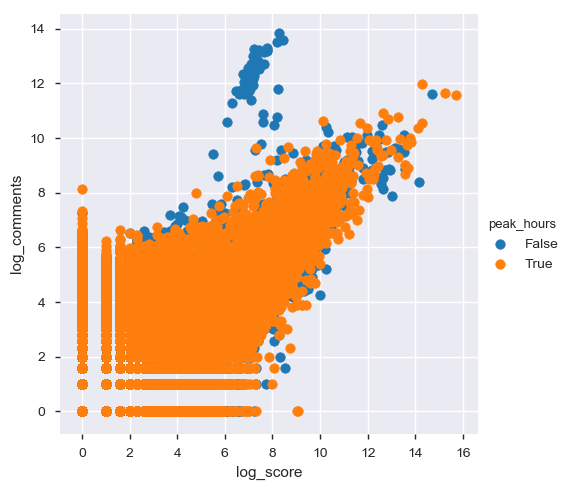

In [68]:
#log score and log comments organized by peak hours
#the odd cluster was likely due to extended conversations during the night

sns.FacetGrid(Crypto_2018,hue='peak_hours',size=5) \
    .map(plt.scatter,'log_score','log_comments')\
    .add_legend()

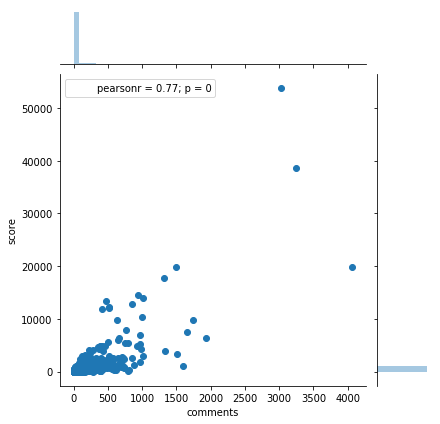

In [34]:
#the scatter plot of scores vs comments for only during peak hours

sns.jointplot(x = Crypto_2018[Crypto_2018['peak_hours']==True]['comments'],y=Crypto_2018[Crypto_2018['peak_hours']==True]['score'])

In [35]:
#maybe having a video has an effect?
Crypto_2018[Crypto_2018['is_video']].describe()

,comments,score,hour,log_score,log_comments,k
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.0
mean,18.247619,79.742857,12.123810,3.441338,2.133817,1.0
std,93.464697,397.673910,7.355918,2.422613,1.742626,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2.000000,4.000000,5.000000,2.000000,1.000000,1.0
50%,4.000000,12.000000,14.000000,3.584963,2.000000,1.0
75%,9.000000,29.000000,19.000000,4.857981,3.169925,1.0
max,911.000000,3443.000000,23.000000,11.749450,9.831307,1.0


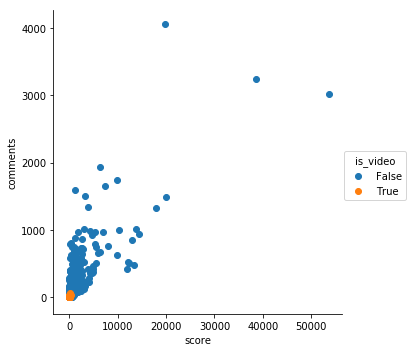

In [36]:
#the scatter plot of scores vs comments for only during peak hours, organized by videos

sns.FacetGrid(Crypto_2018[Crypto_2018['peak_hours']==True],hue='is_video',size=5) \
    .map(plt.scatter,'score','comments')\
    .add_legend()

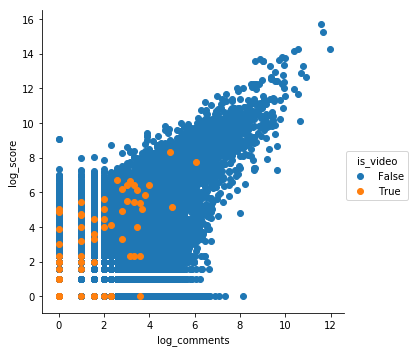

In [37]:
#the scatter plot of log scores vs log comments for only during peak hours, organized by videos

sns.FacetGrid(Crypto_2018[Crypto_2018['peak_hours']==True],hue='is_video',size=5) \
    .map(plt.scatter,'log_comments','log_score')\
    .add_legend()

In [38]:
#doesnt seem like videos has much of an effect

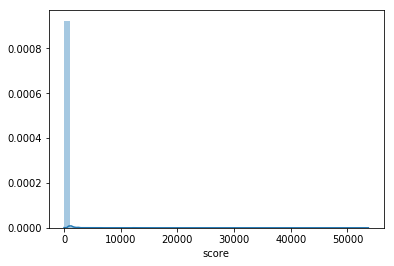

In [39]:
#so wildly skewed
sns.distplot(Crypto_2018[Crypto_2018['peak_hours']==True].score)

In [40]:
Crypto_2018[Crypto_2018['peak_hours']==True].score.describe()

count    22117.000000
mean        55.827689
std        609.474949
min          0.000000
25%          1.000000
50%          3.000000
75%         11.000000
max      53704.000000
Name: score, dtype: float64

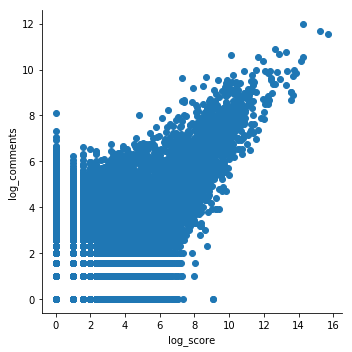

In [41]:
sns.FacetGrid(Crypto_2018[Crypto_2018['peak_hours']==True],size=5)\
    .map(plt.scatter,'log_score','log_comments')

In [42]:
Crypto_2018[Crypto_2018['peak_hours']==False].score.describe()

count    13482.000000
mean        59.089156
std        453.860251
min          0.000000
25%          1.000000
50%          4.000000
75%         13.000000
max      26340.000000
Name: score, dtype: float64

In [43]:
print('Mean Comments during Peak hours')
print('True  : '+str(Crypto_2018.groupby('peak_hours',sort=False)['comments'].mean()[1]))
print('False : '+str(Crypto_2018.groupby('peak_hours',sort=False)['comments'].mean()[0]))

Mean Comments during Peak hours
True  : 16.331193199801056
False : 41.2714730752114


In [44]:
print('Mean Score during Peak hours')
print('True  : '+str(Crypto_2018.groupby('peak_hours',sort=False)['score'].mean()[1]))
print('False : '+str(Crypto_2018.groupby('peak_hours',sort=False)['score'].mean()[0]))

Mean Score during Peak hours
True  : 55.82768910792603
False : 59.08915591158582


In [45]:
print('Median Comments during Peak hours')
print('True  : '+str(Crypto_2018.groupby('peak_hours',sort=False)['comments'].median()[1]))
print('False : '+str(Crypto_2018.groupby('peak_hours',sort=False)['comments'].median()[0]))

Median Comments during Peak hours
True  : 5
False : 6


In [46]:
print('Median Score during Peak hours')
print('True  : '+str(Crypto_2018.groupby('peak_hours',sort=False)['score'].median()[1]))
print('False : '+str(Crypto_2018.groupby('peak_hours',sort=False)['score'].median()[0]))

Median Score during Peak hours
True  : 3
False : 4


In [67]:
Crypto_2018['target']=Crypto_2018['score']>10

In [52]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split


In [81]:
X = Crypto_2018[Crypto_2018['peak_hours']==True].title.str.lower()
y = Crypto_2018[Crypto_2018['peak_hours']==True].target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

cvec = CountVectorizer(stop_words='english')

cvec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [83]:
X_train_df = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names())

X_test_df = pd.DataFrame(cvec.transform(X_test).todense(),
                      columns=cvec.get_feature_names())

In [85]:
from sklearn.linear_model import LogisticRegression
#logisticRegression based on countvertorized words
lr = LogisticRegression()
lr.fit(X_train_df, y_train)
lr.score(X_test_df, y_test)

values = pd.DataFrame(lr.coef_[0],index=X_train_df.columns,columns=['Coef'])

In [86]:
values.sort_values('Coef',ascending=False).head(10)

,Coef
bounty0x,2.784323
navcoin,2.531609
pinkdate,2.173896
iota,1.988986
ark,1.799999
funfair,1.768115
stellar,1.738085
ecc,1.709620
bosch,1.705847
enigma,1.691445


In [87]:
values.sort_values('Coef',ascending=True).head(10)

,Coef
wrong,-1.440664
rules,-1.435313
question,-1.431729
pulse,-1.379705
13,-1.332353
addresses,-1.326878
dash,-1.308434
dedicated,-1.276395
smaller,-1.263131
idea,-1.258548


In [88]:
X = Crypto_2018[Crypto_2018['peak_hours']==False].title.str.lower()
y = Crypto_2018[Crypto_2018['peak_hours']==False].target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

cvec = CountVectorizer(stop_words='english')

cvec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [89]:
X_train_df = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names())

X_test_df = pd.DataFrame(cvec.transform(X_test).todense(),
                      columns=cvec.get_feature_names())

In [90]:
#logisticRegression based on countvertorized words
lr = LogisticRegression()
lr.fit(X_train_df, y_train)
lr.score(X_test_df, y_test)

values = pd.DataFrame(lr.coef_[0],index=X_train_df.columns,columns=['Coef'])

In [91]:
values.sort_values('Coef',ascending=False).head(10)

,Coef
bounty0x,2.346121
enigma,2.142826
navcoin,1.987032
waltonchain,1.879054
enjin,1.792422
ark,1.750226
vechain,1.738836
stay,1.733630
nav,1.638027
coss,1.579015


In [92]:
values.sort_values('Coef',ascending=True).head(10)

,Coef
question,-1.612788
hackers,-1.278829
lift,-1.172001
gainers,-1.171892
waves,-1.143917
distributed,-1.105819
profit,-1.100407
needed,-1.076739
miner,-1.070367
cloud,-1.070060
